## RoBERTa model with toxicity data


2020/10/25

In this version we use RoBERTa to train a model on the 'toxicity' data set, and add additional linear layers, then fine tuning the linear layers according to the characteristics of test data. We test the model on two different data sets.

Student: Xuanyu Su                                                                 
Supervisor: Isar Nejadgholi

In [1]:
import pandas as pd
GAB = pd.read_csv('Data/GabHateCorpus_annotations.tsv', encoding='utf-8',sep='\t')

In [2]:
# voting duplicate
new_label = GAB.groupby('ID')['Hate'].mean() > 0.5

In [3]:
temp = []
for i in new_label:
    if i is True:
        temp.append(1.0)
    else:
        temp.append(0.0)
new_label = temp

In [4]:
new_GAB = GAB.drop_duplicates(subset=['ID'])

In [5]:
new_GAB['Hate'] = temp

<ipython-input-5-a2733beb0c54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_GAB['Hate'] = temp


In [6]:
new_GAB = new_GAB[['Text','Hate']]

In [7]:
new_GAB.head()

,Text,Hate
0,Ah the PSYOPS antifa crew is back. That’s how ...,0.0
4,Get the new Android app update released today ...,0.0
7,Study: Google Pushes Liberal News in Top 5 Sea...,0.0
11,#Breaking: Claiming bias against conservatives...,1.0
15,"“These [companies] are run by sociopaths,” he ...",0.0


In [8]:
new_GAB = new_GAB.reset_index(drop = True)

In [9]:
[print(i) for i in new_GAB.loc[:10]['Text']][0]

Ah the PSYOPS antifa crew is back. That’s how I know we are winning.
Get the new Android app update released today here: https://gab.ai/about/android
Study: Google Pushes Liberal News in Top 5 Search Suggestions https://www.newsbusters.org/blogs/techwatch/corinn...
#Breaking: Claiming bias against conservatives, @FreedomWatchUSA has filed a class action lawsuit against Google, Facebook, Instagram, Twitter, and Apple.
“These [companies] are run by sociopaths,” he said. “These people are complete narcissists. These people ought to be controlled, they ought to be regulated.” At one point during the phone call, Bannon said, “These people are evil.' https://www.vanityfair.com/news/2018/08/steve-bann...
The Belgium government is demanding that Gab remove “hate speech” content. Lol, not gonna happen.
“Therefore, since we are surrounded by so great a cloud of witnesses, let us also lay aside every weight, and sin which clings so closely, and let us run with endurance the race that is set befor

In [10]:
# data preprocessing
import re
from tqdm import tqdm
import emoji

class Word_Preprocessing():
    def eliminate_url(self,df,target):
        print('Start eliminate url: : )')
        df_temp = df
        target_column_name = target
        text = df_temp[target_column_name]
        for i in tqdm(text):
            urls = re.findall(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', i)
            for i in urls:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
    
    def eliminate_username(self,df,target):
        print('Start eliminate username: : )')
        df_temp = df
        target_column_name = target
        for i in tqdm(df_temp[target_column_name]):
            user_name = re.findall(r'@\w*', i)
            for i in user_name:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
     
    def eliminate_hashtag(self, df, target):
        df_temp = df
        target_column_name = target
        for i in tqdm(df_temp[target_column_name]):
            user_name = re.findall(r'#\w*', i)
            for i in user_name:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
    
    def convert_abbreviation(self, df, target):
        df_temp = df
        target_column_name = target
        am = "'m"
        are = "'re"
        have = "'ve"
        not_ = "n't"
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(am, " am"))
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(are, "  are"))
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(have, " have"))
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(not_, " not"))
        return df_temp
        
    def final_check(self,df,target):
        print('Start Final check: ')
        df_temp = df
        target_column_name = target
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x:re.sub(r'[^A-Za-z0-9 ]+', ' ', x).lower())
        return df_temp
            
    def eliminate_symbol(self,df,target):
        print('Start eliminate symbol: : )')
        df_temp = df
        target_column_name = target
        symbol_list = [',',"'",'!','@','$','%','^','&','*','(',')','-','+','?','>','<','=','.',':',';','  ','  ','   ','    ','      ','      ','  ']
        for i in tqdm(symbol_list):
            df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ' '))
        return df_temp
    
    def process_all(self, df,target):
        df_temp = df
        target_column_name = target
        df_fresh = self.convert_abbreviation(df_temp,target_column_name)
        df_remove_url = self.eliminate_url(df_fresh,target_column_name)
        df_eliminate_hashtag = self.eliminate_hashtag(df_remove_url, target_column_name)
        df_remove_username = self.eliminate_username(df_eliminate_hashtag, target_column_name)
        df_remove_symbol = self.eliminate_symbol(df_remove_username, target_column_name)
        df_final_check = self.final_check(df_remove_symbol, target_column_name)
        print("finished!!")
        return df_final_check

In [11]:
word_preprocesser = Word_Preprocessing()

In [12]:
tmp_GAB = word_preprocesser.process_all(new_GAB, 'Text')

  0%|                                                                              | 32/27665 [00:00<01:29, 308.51it/s]

Start eliminate url: : )


  1%|▍                                                                           | 158/27665 [00:00<00:18, 1508.78it/s]

Start eliminate username: : )


 44%|████████████████████████████████████                                             | 12/27 [00:00<00:00, 114.73it/s]

Start eliminate symbol: : )


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 98.66it/s]


Start Final check: 
finished!!


In [13]:
tmp_GAB = word_preprocesser.eliminate_symbol(new_GAB, 'Text')

 52%|██████████████████████████████████████████                                       | 14/27 [00:00<00:00, 133.69it/s]

Start eliminate symbol: : )


100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 115.20it/s]


In [14]:
tmp_GAB.head()

,Text,Hate
0,ah the psyops antifa crew is back that s how i...,0.0
1,get the new android app update released today ...,0.0
2,study google pushes liberal news in top 5 sear...,0.0
3,claiming bias against conservatives has filed...,1.0
4,these companies are run by sociopaths he said...,0.0


In [15]:
[print(i) for i in tmp_GAB.loc[:10]['Text']][0]

ah the psyops antifa crew is back that s how i know we are winning 
get the new android app update released today here 
study google pushes liberal news in top 5 search suggestions 
 claiming bias against conservatives has filed a class action lawsuit against google facebook instagram twitter and apple 
 these companies are run by sociopaths he said these people are complete narcissists these people ought to be controlled they ought to be regulated at one point during the phone call bannon said these people are evil 
the belgium government is demanding that gab remove hate speech content lol not gonna happen 
 therefore since we are surrounded by so great a cloud of witnesses let us also lay aside every weight and sin which clings so closely and let us run with endurance the race that is set before us hebrews 12 1 
social media censorship is out of control 
i wrote an article on the links between feminism and witchcraft the rise of feminist witchcraft 
canadian prime minister justin tr

Text(0.5, 0, 'length')

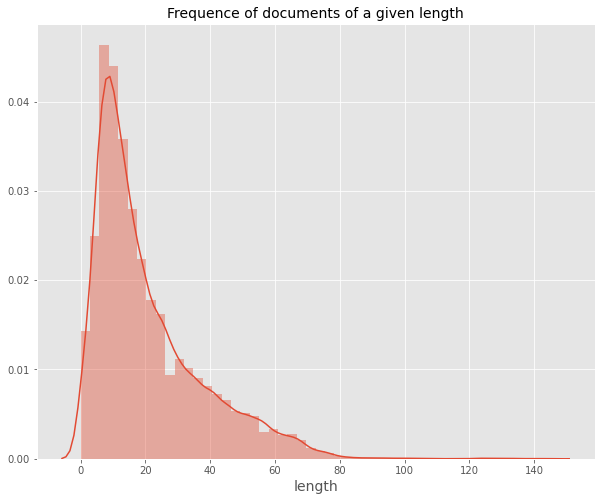

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
tmp_GAB['length'] = tmp_GAB['Text'].apply(lambda x: len(x.split()))
sns.distplot(tmp_GAB[tmp_GAB['length'] < 150]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [42]:
tmp_GAB['Hate'] = tmp_GAB['Hate'].astype(int)

In [44]:
tmp_GAB.to_csv('Data/final_GAB.csv',index=False,header=True)

In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [2]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

## GAB data preprocessing

In [48]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 30
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'Text' : ('Text', text_field), 'Hate' : ('Hate', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path="Data/final_GAB.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
                                                                            stratified=True, 
                                                                            strata_field='Hate')

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.Text), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

## Toxicity data preprocessing

In [19]:
source_folder = 'Data'
destination_folder = 'Model'

In [20]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('toxicity', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='Train_comment_toxity.csv', validation='Val_comment_toxity.csv',
                                           test='Test_comment_toxity.csv', format='CSV', fields=fields, skip_header=True)


train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

## checkpoint

In [21]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

## additional linear layers

In [22]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x1 = self.d1(x)
        x2 = self.l1(x1)
        x3 = self.bn1(x2)
        x4 = torch.nn.Tanh()(x3)
        x5 = self.d2(x4)
        x6 = self.l2(x5)
        
        return x6

## pretrain model ( freeze the parameters in RoBERTa model to initialize the parameter in linear layers)

In [30]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        count = 0
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
        
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            print('batch_no [{}/{}]:'.format(count, int(len(train_comment)/BATCH_SIZE)),'training_loss:',loss)
            count+=1
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

## training model

In [31]:
# Training Function
output_path = 'Model_roberta'
def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = output_path):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        count = 0
        for (source, target), _ in train_iter:
            
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)

            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            #loss = output[0]
            print('batch_no [{}/{}]:'.format(count, int(len(train_comment)/BATCH_SIZE)),'training_loss:',loss)
            count+=1
            loss.backward()
            
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)

                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)

                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [ ]:
# Main training loop
NUM_EPOCHS = 6
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier(0.4)
model = model.to(device)

print("======================= Start pretraining ==============================")



optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)
pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 12
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

## plot results

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# Evaluation Function
import seaborn as sns
def evaluate(model, test_loader):
    y_pred = []
    y_true = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)
                y_prob.extend(output.tolist())
                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    label_true = []
    for i in y_true:
        if i == 1:
            label_true.append([1,0])
        else:
            label_true.append([0,1])
    y_prob_final = []
    for i in range(len(y_prob)):
        tempA = abs(y_prob[i][0])
        tempB = abs(y_prob[i][1])
        y_prob_final.append(tempB/(tempA+tempB))

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    plt.figure(1, figsize=(20,8))

    ax= plt.subplot(121)
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
    ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
    fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
    plt.subplot(122)
    lw = 2
    plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
             lw=lw, label='roc curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

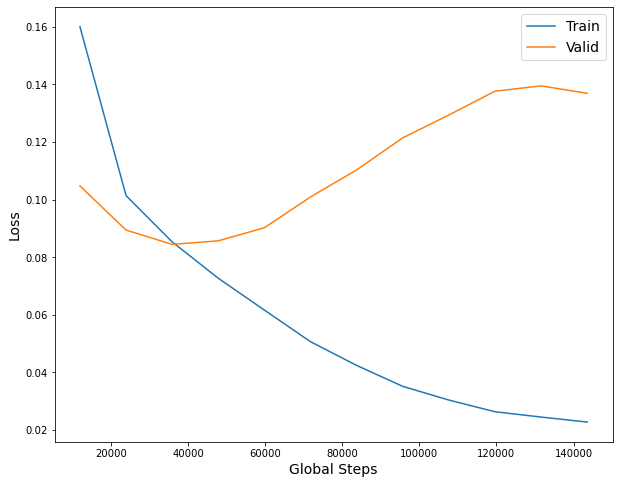

In [38]:
# in-deomain test
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           1     0.8533    0.8071    0.8295      3048
           0     0.9797    0.9853    0.9825     28818

    accuracy                         0.9683     31866
   macro avg     0.9165    0.8962    0.9060     31866
weighted avg     0.9676    0.9683    0.9679     31866



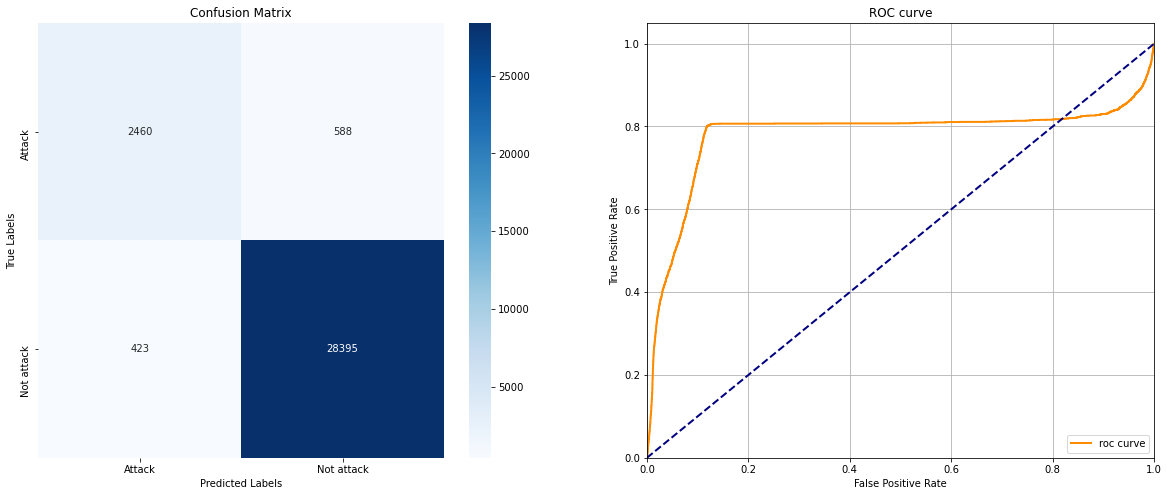

In [90]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

evaluate(model, test_iter)

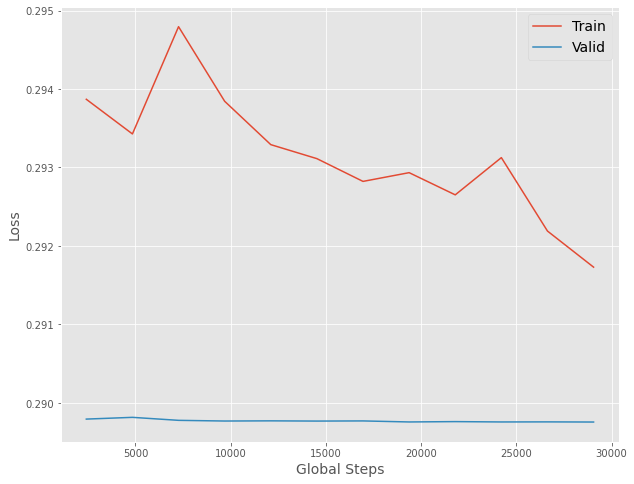

In [54]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## test on gab data 

Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       467
           0     0.9156    1.0000    0.9559      5066

    accuracy                         0.9156      5533
   macro avg     0.4578    0.5000    0.4780      5533
weighted avg     0.8383    0.9156    0.8753      5533



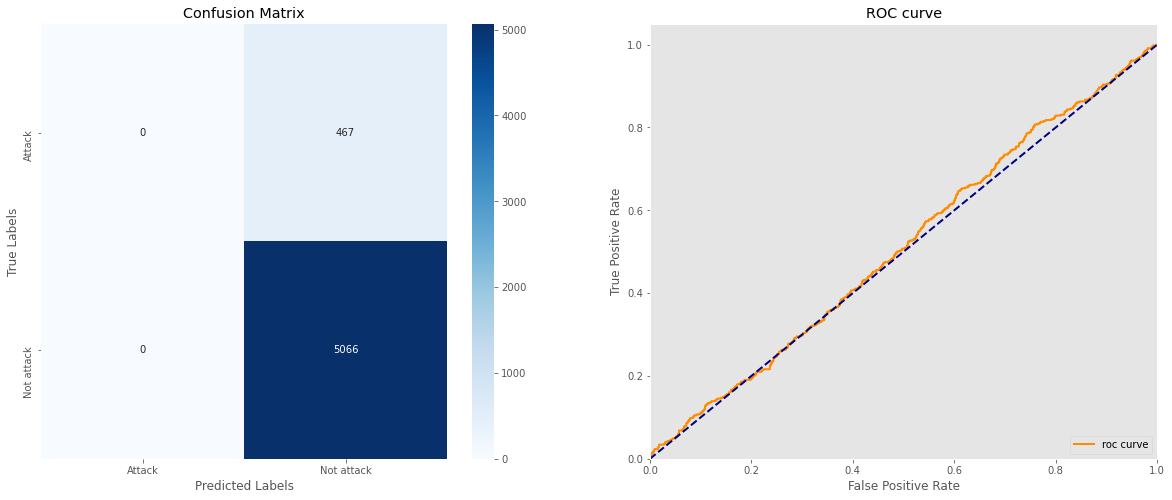

In [62]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

evaluate(model, test_iter)

## 2400 Covid data preprocessing

In [129]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

0.08447376631685106

In [130]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# Evaluation Function
import seaborn as sns
def evaluate(model, test_loader):
    y_pred = []
    y_true = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)
                y_prob.extend(output.tolist())
                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    label_true = []
    for i in y_true:
        if i == 1:
            label_true.append([1,0])
        else:
            label_true.append([0,1])
    y_prob_final = []
    for i in range(len(y_prob)):
        tempA = abs(y_prob[i][0])
        tempB = abs(y_prob[i][1])
        y_prob_final.append(tempB/(tempA+tempB))

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    plt.figure(1, figsize=(20,8))

    ax= plt.subplot(121)
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
    ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
    fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
    plt.subplot(122)
    lw = 2
    plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
             lw=lw, label='roc curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [131]:
def embedding(test_file, text_name,label_name):
    # Model parameter
    MAX_SEQ_LEN = 128
    # Set tokenizer hyperparameters.
    BATCH_SIZE = 4
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


    # Define columns to read.
    label_field = Field(sequential=False, use_vocab=False, batch_first=True)
    text_field = Field(use_vocab=False, 
                       tokenize=tokenizer.encode, 
                       include_lengths=False, 
                       batch_first=True,
                       fix_length=MAX_SEQ_LEN, 
                       pad_token=PAD_INDEX, 
                       unk_token=UNK_INDEX)

    fields = {text_name : (text_name, text_field), label_name : (label_name, label_field)}


    # Read preprocessed CSV into TabularDataset and split it into train, test and valid.
    train_data, valid_data, test_data = TabularDataset(path=test_file, 
                                                       format='CSV', 
                                                       fields=fields, 
                                                       skip_header=False).split(split_ratio=[0.70, 0.1, 0.2], 
                                                                                stratified=True, 
                                                                                strata_field=label_name)

    # Create train and validation iterators.
    train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                                   batch_size=BATCH_SIZE,
                                                   device=device,
                                                   shuffle=True,
                                                   sort_key=lambda x: len(x.comment), 
                                                   sort=True, 
                                                   sort_within_batch=False)

    # Test iterator, no shuffling or sorting required.
    test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)
    return train_iter, valid_iter, test_iter

In [132]:
Text_field = 'comment'
label_field = 'attack'
file_field = "Data/test5.csv"
train_iter_2400, valid_iter_2400, test_iter_2400 = embedding(file_field,Text_field ,label_field)

Classification Report:
              precision    recall  f1-score   support

           1     0.5319    0.7353    0.6173        68
           0     0.8696    0.7317    0.7947       164

    accuracy                         0.7328       232
   macro avg     0.7007    0.7335    0.7060       232
weighted avg     0.7706    0.7328    0.7427       232



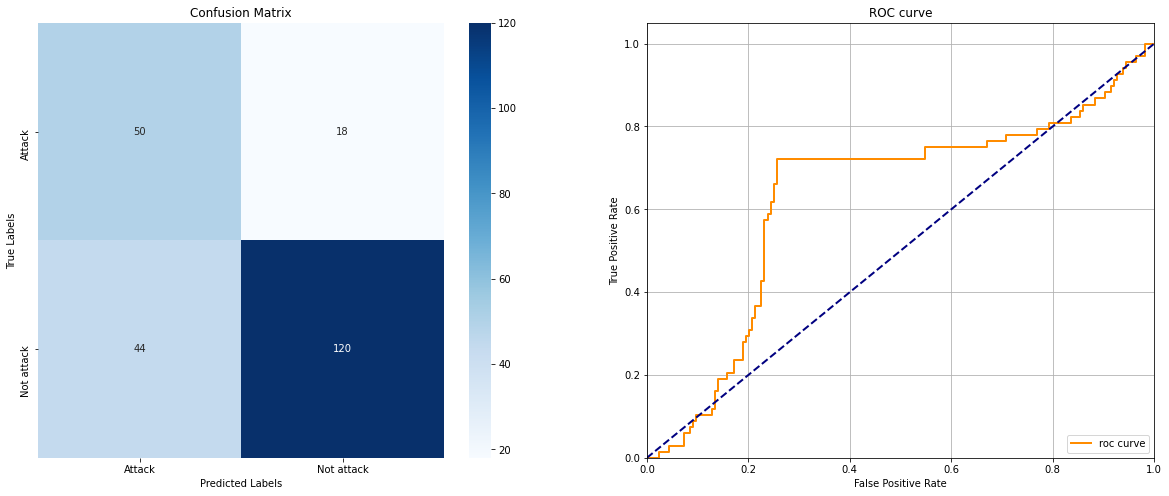

In [133]:
evaluate(model, test_iter_2400)

## Fine tuning on linear layers

In [134]:
model

ROBERTAClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [135]:
def Finetuning(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        count = 0
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
        
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            print('batch_no [{}/{}]:'.format(count, int(len(train_iter))),'training_loss:',loss)
            count+=1
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
    
    print('finetuning done!')
    return model

In [ ]:
NUM_EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                          num_training_steps=steps_per_epoch*NUM_EPOCHS)
print("======================= Start finetuning ==============================")
model_fintuned = Finetuning(model=model,
         train_iter=train_iter_2400, 
         valid_iter=valid_iter_2400,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

## test on 2400 covid data

Classification Report:
              precision    recall  f1-score   support

           1     0.5581    0.7059    0.6234        68
           0     0.8630    0.7683    0.8129       164

    accuracy                         0.7500       232
   macro avg     0.7106    0.7371    0.7181       232
weighted avg     0.7737    0.7500    0.7574       232



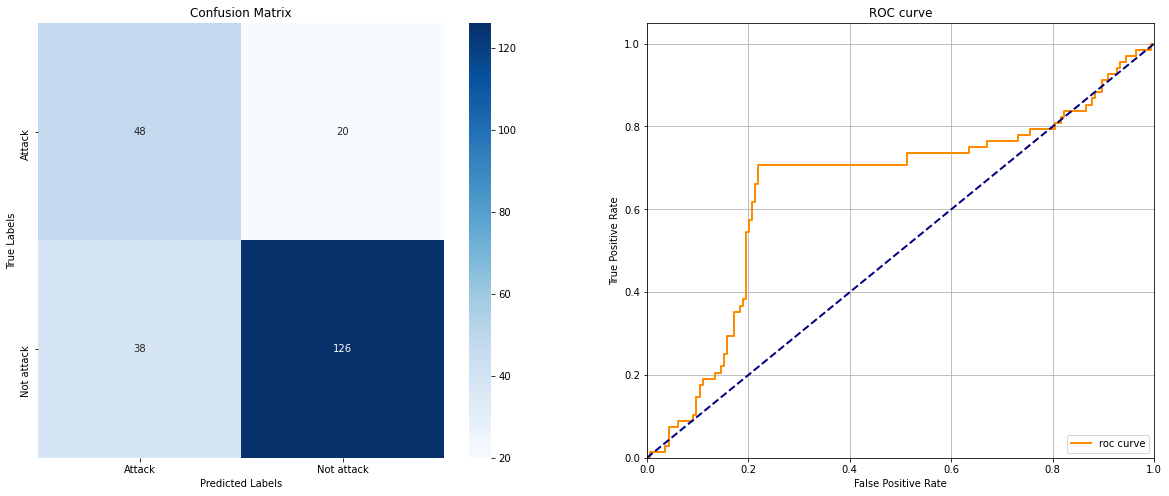

In [137]:
evaluate(model_fintuned, test_iter_2400)

## fine tuning and test on gab data 

In [123]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

0.08447376631685106

In [124]:
def embedding_on_GAB(test_file, text_name,label_name):
    # Model parameter
    MAX_SEQ_LEN = 128
    # Set tokenizer hyperparameters.
    BATCH_SIZE = 4
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


    # Define columns to read.
    label_field = Field(sequential=False, use_vocab=False, batch_first=True)
    text_field = Field(use_vocab=False, 
                       tokenize=tokenizer.encode, 
                       include_lengths=False, 
                       batch_first=True,
                       fix_length=MAX_SEQ_LEN, 
                       pad_token=PAD_INDEX, 
                       unk_token=UNK_INDEX)

    fields = {text_name : (text_name, text_field), label_name : (label_name, label_field)}


    # Read preprocessed CSV into TabularDataset and split it into train, test and valid.
    train_data, valid_data, test_data = TabularDataset(path=test_file, 
                                                       format='CSV', 
                                                       fields=fields, 
                                                       skip_header=False).split(split_ratio=[0.70, 0.1, 0.2], 
                                                                                stratified=True, 
                                                                                strata_field=label_name)

    # Create train and validation iterators.
    train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                                   batch_size=BATCH_SIZE,
                                                   device=device,
                                                   shuffle=True,
                                                   sort_key=lambda x: len(x.Text), 
                                                   sort=True, 
                                                   sort_within_batch=False)

    # Test iterator, no shuffling or sorting required.
    test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)
    return train_iter, valid_iter, test_iter

In [125]:
Text_field = 'Text'
label_field = 'Hate'
file_field = "Data/final_GAB.csv"
train_iter_GAB, valid_iter_GAB, test_iter_GAB = embedding_on_GAB(file_field,Text_field ,label_field)

Classification Report:
              precision    recall  f1-score   support

           1     0.0751    0.1197    0.0923       234
           0     0.9140    0.8638    0.8882      2533

    accuracy                         0.8009      2767
   macro avg     0.4945    0.4917    0.4902      2767
weighted avg     0.8430    0.8009    0.8209      2767



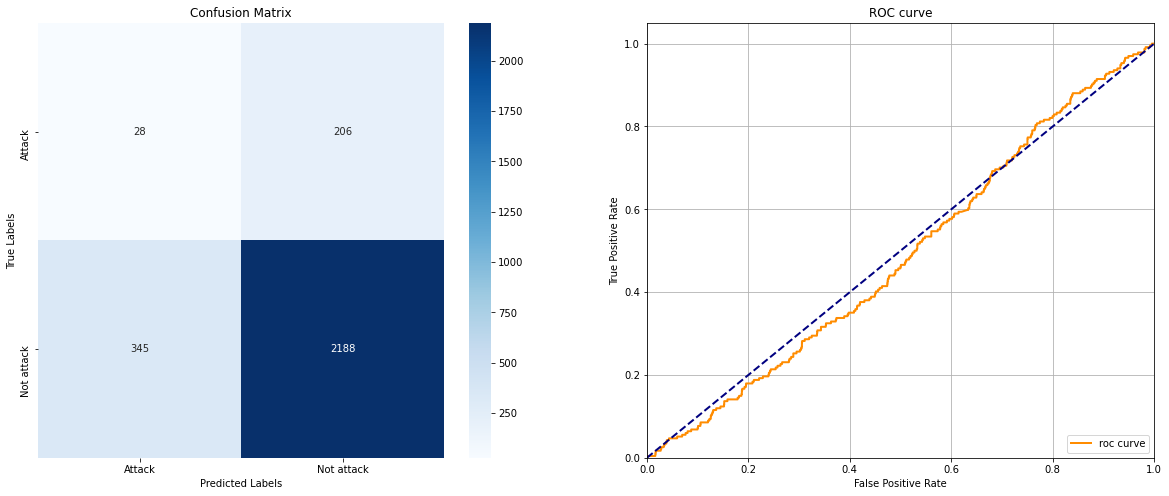

In [126]:
evaluate(model, test_iter_GAB)

In [ ]:
NUM_EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                          num_training_steps=steps_per_epoch*NUM_EPOCHS)
print("======================= Start finetuning ==============================")
model_fintunned_on_BAB = Finetuning(model=model,
         train_iter=train_iter_GAB, 
         valid_iter=valid_iter_GAB,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       234
           0     0.9154    1.0000    0.9558      2533

    accuracy                         0.9154      2767
   macro avg     0.4577    0.5000    0.4779      2767
weighted avg     0.8380    0.9154    0.8750      2767



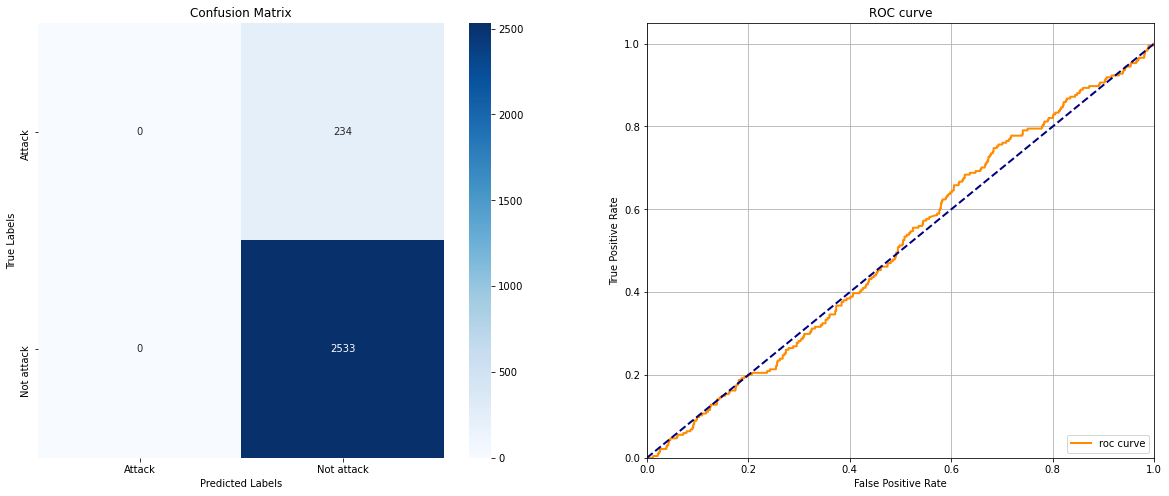

In [139]:
evaluate(model_fintunned_on_BAB, test_iter_GAB)

In [140]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            0.10.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.9.12
anaconda-project                   0.8.3
argh                               0.26.2
asn1crypto                         1.3.0
astroid                            2.4.2
astropy                            4.0.1.post1
astunparse                         1.6.3
atomicwrites                       1.4.0
attrs                              19.3.0
autopep8                           1.5.3


You should consider upgrading via the 'F:\conda\python.exe -m pip install --upgrade pip' command.


Babel                              2.8.0
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.0.post1
bcrypt                             3.1.7
beautifulsoup4                     4.9.1
bitarray                           1.4.0
bkcharts                           0.2
bleach                             3.1.5
blis                               0.4.1
bokeh                              2.1.1
boto                               2.49.0
boto3                              1.15.16
botocore                           1.18.16
Bottleneck                         1.3.2
brotlipy                           0.7.0
cachetools                         4.1.1
catalogue                          1.0.0
certifi                            2020.6.20
cffi                               1.14.0
chardet                            3.0.4
click                              7.1.2
cloudp

In [142]:
!conda list

# packages in environment at F:\conda:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py38_0  
absl-py                   0.10.0                   pypi_0    pypi
alabaster                 0.7.12                     py_0  
anaconda                  2020.07                  py38_0  
anaconda-client           1.7.2                    py38_0  
anaconda-navigator        1.9.12                   py38_0  
anaconda-project          0.8.4                      py_0  
argh                      0.26.2                   py38_0  
asn1crypto                1.3.0                    py38_0  
astroid                   2.4.2                    py38_0  
astropy                   4.0.1.post1      py38he774522_1  
atomicwrites              1.4.0                      py_0  
attrs                     19.3.0                     py_0  
autopep8                  1.5.3                      py_0  
babel                     2.8.0               